In [21]:
!pip install -e ../CauseML

Obtaining file:///home/jovyan/work/CauseML
  Found existing installation: cause-ml 0.0.11
    Uninstalling cause-ml-0.0.11:
      Successfully uninstalled cause-ml-0.0.11
  Running setup.py develop for cause-ml


In [1]:
from cause_ml.parameters import build_parameters_from_metric_levels
from cause_ml.constants import Constants
from cause_ml.data_generation import DataGeneratingProcessWrapper
import cause_ml.data_sources as data_sources
from cause_ml.utilities import extract_treat_and_control_data, random_covar_matrix

In [2]:
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import partial
from multiprocessing import Pool
from IPython.display import clear_output
import time as timer

In [4]:
import rpy2
from rpy2 import robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
from rpy2.robjects import IntVector, FloatVector, Matrix, ListVector
numpy2ri.activate()

In [5]:
from IPython.core.debugger import set_trace

## Data Generation Code

In [6]:
PARTIAL_CORRELATION_DEG = 0.1

In [7]:
def generate_original_data(
    prop_score=0.5,
    n_covars=20,
    n_observations=50000):
    
    covariance_matrix = random_covar_matrix(
        dimension=n_covars,
        correlation_deg=PARTIAL_CORRELATION_DEG)

    # Generate random covariates
    covar_data = np.random.multivariate_normal(
        mean=np.full((n_covars,), 0),
        cov=covariance_matrix,
        size=n_observations)
    
    outcome_coeffs = np.random.uniform(-5, 5, size=20)
    
    noise = np.random.normal(size=n_observations)
    Y0 = (covar_data @ outcome_coeffs) + \
        5*((covar_data[:, 0] > 0.5).astype(int)) + \
        noise
    Y1 = Y0 + 8*((covar_data[:, 1] > 0.1).astype(int))
    
    TE = Y1 - Y0
    T = (np.random.uniform(0, 1, size=n_observations) < prop_score).astype(int)
    Y = T*Y1 + (1-T)*Y0
    
    obs_data = pd.DataFrame(data=covar_data)
    obs_data["T"] = T
    obs_data["Y"] = Y
    
    oracle_data = pd.DataFrame({
        "TE": TE,
        "NOISE(Y)": noise,
        "Y0": Y0,
        "Y1": Y1,
        "P(T|X)": prop_score
    })
    
    return obs_data, oracle_data

In [8]:
def generate_original_data_with_normalized_base(
    prop_score=0.5,
    n_covars=20,
    n_observations=50000):
    
    covar_data_source = data_sources.load_random_normal_covariates(
        n_covars=n_covars,
        n_observations=n_observations,
        partial_correlation_degree=PARTIAL_CORRELATION_DEG)
    
    covar_data = covar_data_source.original_covariate_data.to_numpy()
    
    outcome_coeffs = np.random.uniform(-5, 5, size=20)
    
    noise = np.random.normal(size=n_observations)
    Y0 = (covar_data @ outcome_coeffs) + \
        5*((covar_data[:, 0] > 0.5).astype(int)) + \
        noise
    Y1 = Y0 + 8*((covar_data[:, 1] > 0.1).astype(int))
    
    TE = Y1 - Y0
    T = (np.random.uniform(0, 1, size=n_observations) < prop_score).astype(int)
    Y = T*Y1 + (1-T)*Y0
    
    obs_data = covar_data_source.original_covariate_data.copy()
    obs_data["T"] = T
    obs_data["Y"] = Y
    
    oracle_data = pd.DataFrame({
        "TE": TE,
        "NOISE(Y)": noise,
        "Y0": Y0,
        "Y1": Y1,
        "P(T|X)": prop_score
    })
    
    return obs_data, oracle_data

In [9]:
def generate_hybrid_data(
    prop_score=0.5,
    n_covars=20,
    n_observations=50000):
    
    covar_data_source = data_sources.load_random_normal_covariates(
        n_covars=n_covars,
        n_observations=n_observations,
        partial_correlation_degree=PARTIAL_CORRELATION_DEG)

    dgp_params = build_parameters_from_metric_levels({
        Constants.AxisNames.TREATMENT_NONLINEARITY: Constants.AxisLevels.LOW,
        Constants.AxisNames.OUTCOME_NONLINEARITY: Constants.AxisLevels.LOW,
        Constants.AxisNames.TE_HETEROGENEITY: Constants.AxisLevels.LOW
    })
    
    dgp_params.set_parameter("MIN_PROPENSITY_SCORE", 0.001)
    dgp_params.set_parameter("MAX_PROPENSITY_SCORE", 0.9999)
    dgp_params.set_parameter("TREATMENT_EFFECT_HETEROGENEITY", 0.05)
    dgp_params.set_parameter("OUTCOME_NOISE_TAIL_THICKNESS", 300)
    dgp_params.set_parameter("TARGET_PROPENSITY_SCORE", prop_score)
    dgp_params.set_parameter("ACTUAL_CONFOUNDER_ALIGNMENT", 0)
    
    dgp_params.set_parameter("TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY",
                             {
                                "LINEAR": 0,
                                "POLY_QUAD": 0.0,
                                "POLY_CUBIC": 0.0,
                                "STEP_JUMP": 0,
                                "STEP_KINK": 0,
                                "INTERACTION_TWO_WAY": 0,
                                "INTERACTION_THREE_WAY": 0
                             })
    dgp_params.set_parameter("OUTCOME_MECHANISM_COVARIATE_SELECTION_PROBABILITY",
                             {
                                "LINEAR": 1,
                                "POLY_QUAD": 0.0,
                                "POLY_CUBIC": 0.0,
                                "STEP_JUMP": 0.05,
                                "STEP_KINK": 0,
                                "INTERACTION_TWO_WAY": 0,
                                "INTERACTION_THREE_WAY": 0
                             })

    dgp_wrapper = DataGeneratingProcessWrapper(
        parameters=dgp_params, data_source=covar_data_source)
    
    dgp_wrapper.sample_dgp()
    _ = dgp_wrapper.generate_dataset()
    
    obs_data = dgp_wrapper.get_observed_data()
    oracle_data = dgp_wrapper.get_oracle_data()
    
    return obs_data, oracle_data

In [10]:
observed_data, unobservable_data = generate_hybrid_data(prop_score=0.5)
# observed_data, unobservable_data = generate_original_data(
#     prop_score=0.5, n_observations=int(1e2))
observed_data.head()

,T,Y,X0,X1,X2,X3,X4,X5,X6,X7,...,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19
0,1,0.035169,-0.553937,-0.316391,-0.251641,0.039764,0.356782,-0.537509,0.404696,0.171469,...,0.011707,-0.243400,-0.165120,-0.429606,0.099352,0.085782,-0.284121,0.091488,-0.244379,0.280916
1,0,-1.450418,0.083183,0.052855,0.320301,-0.213753,-0.399401,0.224129,0.308250,-0.304984,...,-0.088197,-0.314636,-0.336625,-0.031229,-0.104744,-0.204335,-0.050995,0.318300,0.263978,0.113081
2,1,-0.458966,0.608740,0.453377,0.220531,-0.511780,0.115730,0.190976,0.001794,0.357678,...,-0.254547,-0.019882,-0.546328,-0.481406,-0.188754,-0.040756,-0.120047,-0.040989,-0.087847,-0.229669
3,1,-0.386605,-0.148444,0.047110,0.455571,-0.103845,-0.288062,-0.234315,0.260060,0.378070,...,-0.060680,0.084837,0.014410,-0.605391,-0.156044,-0.238167,-0.014281,0.098553,-0.136499,-0.122645
4,0,-3.088262,0.457883,0.537641,-0.101952,-0.536673,-0.023098,0.571582,-0.200843,0.307428,...,-0.176044,0.098083,-0.256165,0.231086,0.140495,0.253614,0.042826,0.299462,-0.344134,0.001324


In [12]:
unobservable_data.head()

,logit(P(T|X)),P(T|X),Y0,Y1,TE,TRANSFORMED_X0,TRANSFORMED_X1,TRANSFORMED_X2,TRANSFORMED_X3,TRANSFORMED_X4,...,TRANSFORMED_X14,TRANSFORMED_X15,TRANSFORMED_X16,TRANSFORMED_X17,TRANSFORMED_X18,TRANSFORMED_X19,TRANSFORMED_X20,TRANSFORMED_X21,TRANSFORMED_X22,NOISE(Y)
44059,NaN,NaN,0.898772,2.893173,1.994401,0.002241,0.022491,0.006687,-0.004471,0.008934,...,0.029509,-0.005281,0.000,0.000706,-0.027663,0.023,0.008298,0.005327,0.002991,0.396
30485,NaN,NaN,1.405533,1.575627,0.170094,0.000859,-0.019997,0.022337,-0.003215,0.013107,...,0.003770,-0.004111,0.102,0.005184,0.139809,0.023,0.015252,0.072178,0.001881,-0.108
3137,NaN,NaN,1.595822,2.010304,0.414481,0.000245,-0.014305,0.002999,0.031739,0.000809,...,-0.003448,0.004645,0.000,0.000179,0.045145,0.023,0.007580,0.038583,-0.003410,0.048
40494,NaN,NaN,-0.610956,1.857928,2.468884,0.001160,0.033542,0.011503,-0.017518,0.029199,...,-0.009345,0.003687,0.102,0.002213,-0.035583,0.023,-0.007908,0.006710,0.001575,0.184
28234,NaN,NaN,1.493577,3.462987,1.969410,0.000358,0.021909,0.000178,0.023755,0.011976,...,-0.016746,-0.007061,0.000,-0.000455,0.017371,0.023,0.007468,-0.018878,-0.005145,-0.173


## Model Code

In [13]:
def build_mlp():
    return MLPRegressor(
        hidden_layer_sizes=(50, 25, 10),
        activation='relu',
        solver='adam',
        batch_size='auto',
        learning_rate='constant',
        learning_rate_init=0.001,
        power_t=0.5,
        max_iter=1000,
        shuffle=True,
        random_state=1,
        tol=0.0001,
        verbose=False,
        warm_start=False,
        early_stopping=True,
        validation_fraction=0.10,
        epsilon=1e-08,
        n_iter_no_change=5)

def build_reg_forest():
    return RandomForestRegressor(n_estimators=30)

In [14]:
def scikit_T_learner(model_builder, data):
    treated_data, control_data = extract_treat_and_control_data(
        data, data["T"])
    
    # train u1
    u1 = model_builder()
    X_treated = treated_data.drop(["T", "Y"], axis=1)
    u1.fit(X_treated, treated_data["Y"])
    
    # train u0
    u0 = model_builder()
    X_control = control_data.drop(["T", "Y"], axis=1)
    u0.fit(X_control, control_data["Y"])
    
    # Generate potential outcome predictions
    X = data.drop(["T", "Y"], axis=1)
    y_1_predicted = u1.predict(X)
    y_0_predicted = u0.predict(X)
    
    ITE_pred = y_1_predicted - y_0_predicted
    
    return ITE_pred, u1, u0

In [15]:
def scikit_S_learner(model_builder, data):
    # train u1
    u = model_builder()
    X = data.drop("Y", axis=1)
    u.fit(X, data["Y"])
    
    # Generate potential outcomes
    X_under_treatment = X.copy()
    X_under_treatment["T"] = 1
    
    X_under_control = X.copy()
    X_under_control["T"] = 0
    
    y_1_predicted = u.predict(X_under_treatment)
    y_0_predicted = u.predict(X_under_control)
    y_1_predicted - y_0_predicted
    
    ITE_pred = y_1_predicted - y_0_predicted
    
    return  ITE_pred

In [16]:
def scikit_X_learner(model_builder, data, prop_score, u1=None, u0=None):
    treated_data, control_data = extract_treat_and_control_data(
        data, data["T"])
    X_treated = treated_data.drop(["T", "Y"], axis=1)
    X_control = control_data.drop(["T", "Y"], axis=1)

    if u1 is None:
        # train u1
        u1 = model_builder()
        u1.fit(X_treated, treated_data["Y"])
    
    if u0 is None:
        # train u0
        u0 = model_builder()
        u0.fit(X_control, control_data["Y"])
    
    # Find individual treatment effects for treated/controls
    itet = treated_data["Y"] - u0.predict(X_treated)
    itec =  u1.predict(X_control) - control_data["Y"]
    
    # Fit models to the treated and controls
    te1 = model_builder()
    te1.fit(X_treated, itet)
    
    te0 = model_builder()
    te0.fit(X_control, itec)
    
    X = data.drop(["T", "Y"], axis=1)
    te1_predicted = te1.predict(X)
    te0_predicted = te0.predict(X)
    
    # Estimate prop scores
#     lm = LogisticRegression(solver="lbfgs")
#     lm.fit(X, data["T"])
#     prop_scores = lm.predict(X)
    
    # Down-weight observes which are likely to belong
    # to other class.
    te = prop_score*te0_predicted + (1-prop_score)*te1_predicted
    
    return te

## Experiment Code

In [17]:
def score_ITE(ITE_true, ITE_pred):
    return np.mean((ITE_true-ITE_pred)**2)

In [18]:
def evaluate_scikit_learners(model_builder, observed_data, unobservable_data):
    ITE_true = unobservable_data["TE"]
    prop_score_true = unobservable_data["P(T|X)"]
    
    # T learner
    ITE_pred, u1, u0 = scikit_T_learner(model_builder, observed_data)
    T_loss = score_ITE(ITE_true, ITE_pred)
    
    # S learner
    ITE_pred = scikit_S_learner(model_builder, observed_data)
    S_loss = score_ITE(ITE_true, ITE_pred)
    
    # X learner
    ITE_pred = scikit_X_learner(model_builder, observed_data, prop_score_true, u1, u0)
    X_loss = score_ITE(ITE_true, ITE_pred)
    
    return T_loss, S_loss, X_loss

In [ ]:
learner_func = partial(evaluate_scikit_learners, build_reg_forest)
%time learner_func(observed_data, unobservable_data)

In [22]:
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage

with open("R Code/honest_trees.R", "r") as prog:
    R_prog = ''.join(prog.readlines())
    HonestTrees = SignatureTranslatedAnonymousPackage(R_prog, "HonestTrees")
    
def evaluate_htree_learners(observed_data, unobservable_data):
    '''
    R-based HTE, NO train-test split.
    '''
    tau = unobservable_data["TE"].to_numpy()
    X = observed_data.drop(["Y", "T"], axis=1).to_numpy()
    y = observed_data["Y"].to_numpy()
    t = observed_data["T"].to_numpy()
    
    X_train, X_test, y_train, _, t_train, _, _, tau_test = \
        train_test_split(
            X, y, t, tau,
            stratify=t,
            test_size=0.2, random_state=42)
    
    ITE_true = unobservable_data["TE"].to_numpy()
    y_train = FloatVector(y_train)
    t_train = IntVector(t_train)
    tau_test = FloatVector(tau_test)
    return tuple(HonestTrees.HRF_learners(
        X_train, y_train, t_train, X_test, tau_test, 4))

In [26]:
%time evaluate_htree_learners(observed_data, unobservable_data)

CPU times: user 4.04 s, sys: 308 ms, total: 4.35 s
Wall time: 1.03 s


(3.949935852594812, 17.131452188664213, 5.68588020017316)

In [23]:
def run_trial(trial_index, 
              data_gen_func,
              learner_eval_func,
              prop_score=0.5,
              n_covars=20,
              n_observations=50000):
    
    # Generate random data
    observed_data, unobservable_data = data_gen_func(
        prop_score=prop_score,
        n_covars=n_covars,
        n_observations=n_observations)
    
    # Train and evaluate learners and get loss for T, S, and X.
    learner_losses = learner_eval_func(observed_data, unobservable_data)
    
    return trial_index, learner_losses

In [33]:
def run_experiment(data_gen_func, learner_func, prop_score,
                   N_obs_levels, N_trials,
                   exec_pool, verbose=False, **kwargs):
    results = []
    for n_obs in N_obs_levels:
        if verbose:
            print(f"Running at N={n_obs}. Percent done:", end=" ")
        
        trial_func = partial(run_trial,
            data_gen_func=data_gen_func,
            learner_eval_func=learner_func,
            prop_score=prop_score,
            n_observations=n_obs)

        trial_results = []

        completed_trial_count = 0
        if exec_pool is not None:
            for _, result_row in exec_pool.imap_unordered(trial_func, range(N_trials)):
                trial_results.append(result_row)
                completed_trial_count += 1
                incomplete = N_trials - completed_trial_count
                if verbose:
                    print(int(100*completed_trial_count/N_trials), end=" ")
        else:
            for i in range(N_trials):
                _, result_row = trial_func(i)
                trial_results.append(result_row)
                completed_trial_count += 1
                incomplete = N_trials - completed_trial_count
                if verbose:
                    print(int(100*completed_trial_count/N_trials), end=" ")
    
        trial_results = np.array(trial_results)
        results.append(np.mean(trial_results, axis=0))
        if verbose:
            print("")
        
    return results

In [47]:
def execute_config(config, verbose=True):
    N_procs = config["N_procs"]
    if N_procs>1:
        with Pool(processes=N_procs) as pool:
            results = run_experiment(**config, exec_pool=pool, verbose=verbose)
    else:
        results = run_experiment(**config, exec_pool=None, verbose=verbose)
    
    res_file = persist_result(config, results)
    return results, res_file

In [50]:
N_obs_levels = np.logspace(3, 5.5, 12).astype(int)
N_obs_levels = [1000, 2000, 5000]

learner_funcs = {
    "regression_forest": partial(evaluate_scikit_learners, build_reg_forest),
    "MLP": partial(evaluate_scikit_learners, build_mlp),
    "Honest Forest": evaluate_htree_learners
}

data_funcs = {
    "original": generate_original_data,
    "original_normed": generate_original_data_with_normalized_base,
    "hybrid": generate_hybrid_data
}

exp_conf = {
    "data_gen_func": data_funcs["hybrid"],
    "learner_func": learner_funcs["Honest Forest"],
    "prop_score": 0.01,
    "N_obs_levels": N_obs_levels,
    "N_trials": 5,
    "N_procs": 2
}

N_obs_levels

[1000, 2000, 5000]

In [51]:
%time results, _ = execute_config(exp_conf)

Running at N=1000. Percent done: 20 40 60 80 100 
Running at N=2000. Percent done: 20 40 60 80 100 
Running at N=5000. Percent done: 20 40 60 80 100 
CPU times: user 140 ms, sys: 40 ms, total: 180 ms
Wall time: 50.6 s


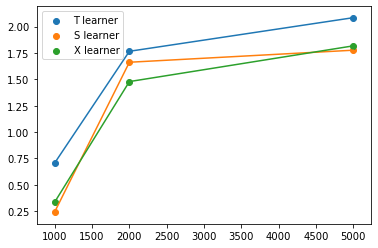

In [52]:
results = np.array(results)
names = ["T learner", "S learner", "X learner"]
N_levels = exp_conf["N_obs_levels"]
for i, name in enumerate(names):
    plt.scatter(N_levels, results[:, i], label=name)
    plt.plot(N_levels, results[:, i])

plt.legend()
plt.show()

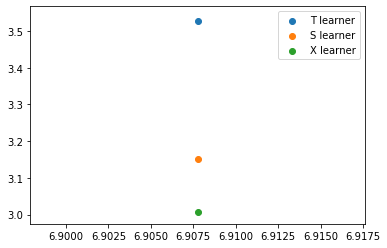

In [39]:
results = np.array(results)
names = ["T learner", "S learner", "X learner"]
for i, name in enumerate(names):
    plt.scatter(np.log(N_obs_levels), np.log(results[:, i]), label=name)

plt.legend()
plt.show()

## Results Caching

In [44]:
import pickle
import uuid
import datetime

RESULT_DIR = "results/kunzel-1/"

def persist_result(config, results):
    unique_filename = str(uuid.uuid4())
    timestamp = str(datetime.datetime.now())

    file_path = RESULT_DIR + unique_filename + " " + timestamp
    result_entry = {
        "configuration": config,
        "result": results
    }

    with open(file_path, "wb") as res_file:
        pickle.dump(result_entry, res_file)
    
    return file_path

## Experiments

In [70]:
N_obs_levels = np.logspace(3.5, 5.5, 12).astype(int)[:-2]

learner_funcs = {
#     "MLP": (partial(evaluate_scikit_learners, build_mlp), 3),
    "Honest Forest": (evaluate_htree_learners, 2)
}

data_funcs = {
#     "original": generate_original_data,
#     "original_normed": generate_original_data_with_normalized_base,
    "hybrid": generate_hybrid_data
}

configs = []
for data_gen_fun_name in data_funcs.keys():
    for learner_func_name in learner_funcs.keys():
        learner_func, cores = learner_funcs[learner_func_name]
        exp_conf = {
            "data_gen_func": data_funcs[data_gen_fun_name],
            "learner_func": learner_func,
            "prop_score": 0.01,
            "N_obs_levels": N_obs_levels,
            "N_trials": 30,
            "N_procs": cores
        }
        configs.append(exp_conf)
        
N_obs_levels

array([  3162,   4806,   7305,  11103,  16876,  25650,  38986,  59255,
        90062, 136887])

In [63]:
result_files = []
for config in configs:
    %time _, result_file = execute_config(config, verbose=False)
    result_files.append(result_file)

CPU times: user 610 ms, sys: 340 ms, total: 950 ms
Wall time: 7min 45s
